In [1]:
import numpy as np
from numpy.random import default_rng
from numpy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [28]:
def generate_data(rng_mnumber = 0):
  N = 1024
  x = (2*np.pi*np.arange(1,N+1)/N)
  rng = default_rng(rng_mnumber)
  u = rng.standard_normal(N)
  #u = -np.sin(x) + 2*np.cos(2*x) + 3 * np.cos(3*x) - 4 * np.sin(4*x)
  v = fft(u)
  nu = 0.05

  # spatial grid and initial conditions
  h = 0.001
  k = (np.r_[np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0)]/16)
  L = k**2 - nu*k**4
  exp1 = np.exp(h*L)
  exp2 = np.exp(h*L/2)
  M = 16
  r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
  LR = h*np.repeat([L], M, axis=0).T + np.repeat([r], N, axis=0)
  Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
  f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
  f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
  f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))

  tmax = 4
  step_max = round(tmax/h)
  step_plt = int(tmax/(100*h))
  g = -0.5j*k
  # tt = np.zeros(step_max)
  # uu = np.zeros((N,step_max))
  uu = np.array([u])
  tt = 0

  for step in range(1, step_max):
      t = step*h
      Nv = g*fft(np.real(ifft(v))**2)
      a = exp2*v + Q*Nv
      Na = g*fft(np.real(ifft(a))**2)
      b = exp2*v + Q*Na
      Nb = g*fft(np.real(ifft(b))**2)
      c = exp2*a + Q*(2*Nb - Nv)
      Nc = g*fft(np.real(ifft(c))**2)
      v = exp1*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
      if step % step_plt == 0:
          u = np.real(ifft(v))
          uu = np.append(uu, np.array([u]), axis=0)
          tt = np.hstack((tt, t))
          # uu[:,step] = u
          # tt[step] = t

      
  time_len = -1
  x_span = 64

  uu = uu[0:time_len,int(uu.shape[1]-x_span):int(uu.shape[1]+x_span)]
  x = x[0:int(x_span)]
  tt = tt[0:time_len]

  return uu , x, tt

<br>
<br>
<br>
<br>
<br>

# Dataset generation

In [29]:
uu, x , tt = generate_data(rng_mnumber = 0)

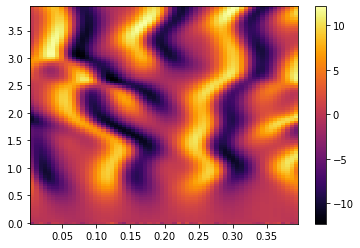

In [30]:
fig, ax = plt.subplots(1,1)
X, T = np.meshgrid(x, tt)
im = ax.pcolormesh(X, T, uu, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.show()

In [32]:
# it generates a number of data with different random initialization
number_of_subdataset = 20

uu_train_X = np.zeros(((uu[0:-1,:].shape[0])*number_of_subdataset,uu[0:-1,:].shape[1]))
uu_train_Y = np.zeros(((uu[0:-1,:].shape[0])*number_of_subdataset,uu[0:-1,:].shape[1]))


for ii in range(number_of_subdataset):
  uu, x , tt = generate_data(rng_mnumber = ii)
  uu_train_X[(uu[0:-1,:].shape[0])*ii:(uu[0:-1,:].shape[0])*ii+uu[0:-1,:].shape[0],:] = uu[0:-1,:]
  uu_train_Y[(uu[0:-1,:].shape[0])*ii:(uu[0:-1,:].shape[0])*ii+uu[0:-1,:].shape[0],:] = uu[1:,:]


<br>
<br>
<br>
<br>
<br>
<br>

# Training the Neural Network for KS Equation forecasting

In [35]:
trainX = uu_train_X
trainy = uu_train_Y

regularizers = False

if regularizers == True:

  # Build model
  deep_approx = tf.keras.models.Sequential()
  deep_approx.add(tf.keras.layers.Dense(600, input_dim=uu_train_X.shape[1], activation='linear', kernel_regularizer=tf.keras.regularizers.L1(0.01)))
  deep_approx.add(tf.keras.layers.Dense(600, activation='linear', kernel_regularizer=tf.keras.regularizers.L1(0.01)))
  deep_approx.add(tf.keras.layers.Dense(uu_train_X.shape[1], activation='linear'))

else:

  deep_approx = keras.models.Sequential()
  deep_approx.add(tf.keras.layers.Dense(100, input_dim=uu_train_X.shape[1], activation='relu'))
  deep_approx.add(tf.keras.layers.Dense(100, activation='relu'))
  deep_approx.add(tf.keras.layers.Dense(uu_train_X.shape[1], activation='linear'))

decayRate = 1e-4
nrSamplesPostValid = 2
learningRate = 3e-3
nEpochs = 500
batchSize = 128
verbosity = 1

# early stopping callback

adam = tf.keras.optimizers.Adam( learning_rate = learningRate, decay = decayRate )

# Compile model
deep_approx.compile(loss='mse', optimizer=adam)

# Fit!
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
History = deep_approx.fit(trainX, trainy, epochs=nEpochs )


Train on 1960 samples
Epoch 1/500
1960/1960 [==============================] - 1s 322us/sample - loss: 8.8378
Epoch 2/500
1960/1960 [==============================] - 0s 138us/sample - loss: 1.7410
Epoch 3/500
1960/1960 [==============================] - 0s 145us/sample - loss: 1.1034
Epoch 4/500
1960/1960 [==============================] - 0s 136us/sample - loss: 0.8261
Epoch 5/500
1960/1960 [==============================] - 0s 137us/sample - loss: 0.6918
Epoch 6/500
1960/1960 [==============================] - 0s 135us/sample - loss: 0.5963
Epoch 7/500
1960/1960 [==============================] - 0s 136us/sample - loss: 0.5238
Epoch 8/500
1960/1960 [==============================] - 0s 136us/sample - loss: 0.4750
Epoch 9/500
1960/1960 [==============================] - 0s 140us/sample - loss: 0.4424
Epoch 10/500
1960/1960 [==============================] - 0s 136us/sample - loss: 0.3836
Epoch 11/500
1960/1960 [==============================] - 0s 128us/sample - loss: 0.3700
Epoch 12

<br>
<br>
<br>
<br>
<br>
<br>

# KS equation forecasting using Neural Network on new initial conditions

In [36]:
uu, x , tt = generate_data(rng_mnumber = 200)

uu_NN = np.zeros_like(uu)
uu_NN[0,:] = uu[0,:]

for ii in tqdm(range(1,len(tt))):
  support = deep_approx.predict(np.reshape(uu_NN[ii-1,:],(1,uu_NN.shape[1])))
  uu_NN[ii,:] = support

100%|██████████| 98/98 [00:04<00:00, 21.41it/s]


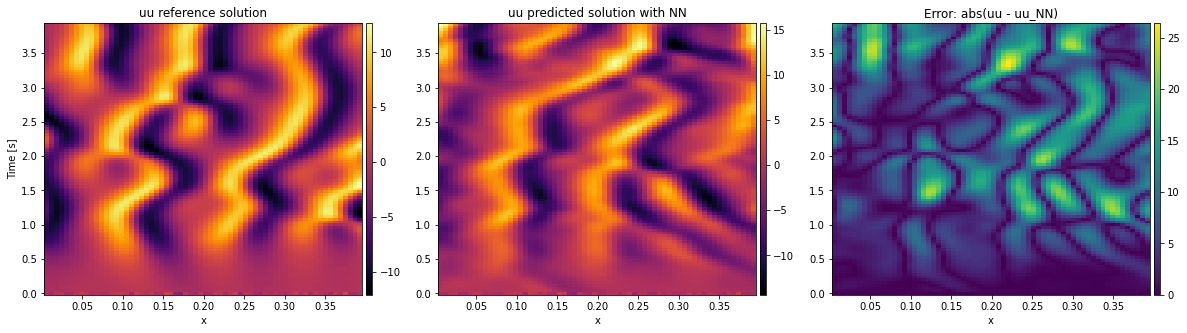

In [68]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

ax[0].set_title('uu reference solution')
im0 = ax[0].pcolormesh(X, T, uu, cmap='inferno', rasterized=True)
ax[0].set_xlabel('x')
ax[0].set_ylabel('Time [s]')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')

ax[1].set_title('uu predicted solution with NN')  
im1 = ax[1].pcolormesh(X, T, uu_NN, cmap='inferno', rasterized=True)
ax[1].set_xlabel('x')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax[2].set_title('Error: abs(uu - uu_NN)')
ax[2].set_xlabel('x')
im2 = ax[2].pcolormesh(X, T, abs(uu-uu_NN), cmap='viridis', rasterized=True)

divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')



plt.show()


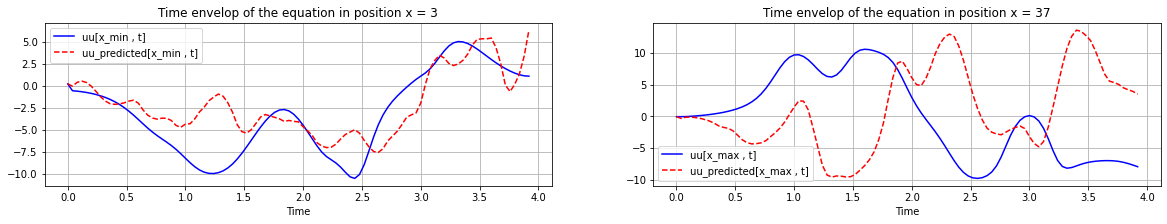

In [70]:
## find max and min error
error_sum = np.sum(abs(uu-uu_NN)/np.max(uu),axis = 0)
min_error_position = np.argmin(error_sum)
max_error_position = np.argmax(error_sum)


title_max = 'Time envelop of the equation in position x = '+str(max_error_position) 
title_min = 'Time envelop of the equation in position x = '+str(min_error_position) 


fig, ax = plt.subplots(1,2,figsize=(20,3))
ax[0].set_title(title_min)
ax[0].plot(tt,uu[:,min_error_position],'b')
ax[0].plot(tt,uu_NN[:,min_error_position],'--r')
ax[0].set_xlabel('Time')
ax[0].legend(['uu[x_min , t]', 'uu_predicted[x_min , t]'])
ax[0].grid()

ax[1].set_title(title_max)
ax[1].plot(tt,uu[:,max_error_position],'b')
ax[1].plot(tt,uu_NN[:,max_error_position],'--r')
ax[1].set_xlabel('Time')
ax[1].legend(['uu[x_max , t]', 'uu_predicted[x_max , t]'])
ax[1].grid()